<a href="https://colab.research.google.com/github/jdmitchell0216/Live-Emotion-Classifier/blob/master/Cnn%2BTransfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Functions

In [0]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.misc as smp
import matplotlib.pyplot as plt
import numpy as np
import os, shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from keras import models, optimizers, Sequential, regularizers, layers
from keras.models import load_model, model_from_json
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import to_categorical
from keras.applications import VGG16, VGG19
from keras.callbacks import EarlyStopping
from keras.layers import Flatten, Dropout, Reshape, Dense, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
import itertools

np.random.seed(123)

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



In [0]:
def plot_confusion_matrix(cm, classes,
             normalize=False,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
#     print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Reading the Data


In [0]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [0]:
cd data


/content/data


List of items in the folder:
*   images.zip (16930 images, combined dataset) 
*   imagesreduced.zip (4630 images, reduced happiness/neutral dataset)
*   train.csv/test.csv (4178 images, original dataset1 from Kaggle)
*   imagereduced_dataset1 (8808 images, dataset1 + reduced)
*   images_flipped(33860 images, combined dataset + combined flipped )








In [0]:
folder_id = '1TF-T5xrlnhaiPIKaoy-awP84eiT1vkkX'
file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()

In [0]:
for file in file_list:
  try:
    downloaded = drive.CreateFile({'id': file['id']})
    downloaded.GetContentFile(downloaded['title'])
  except:
    pass

In [0]:
ls

imagereduced_dataset1.zip  imagesreduced.zip  model10.json        train.csv
images/                    images.zip         model_weights10.h5
images_flipped.zip         __MACOSX/          test.csv


In [0]:
#open up the files with the desired dataset

# !unzip images.zip
# !unzip imagesreduced.zip
# !unzip imagereduced_dataset1.zip
!unzip images_flipped.zip

Archive:  images_flipped.zip
   creating: images_flipped/
  inflating: images_flipped/.DS_Store  
   creating: __MACOSX/images_flipped/
  inflating: __MACOSX/images_flipped/._.DS_Store  
   creating: images_flipped/fear/
  inflating: images_flipped/fear/first_data_set_image__2887__2.png  
  inflating: images_flipped/fear/first_data_set_image__3112__2.png  
  inflating: images_flipped/fear/first_data_set_image__3012__2.png  
  inflating: images_flipped/fear/first_data_set_image__2209__2.png  
  inflating: images_flipped/fear/f_first_data_set_image__2000__2.png  
  inflating: images_flipped/fear/f_first_data_set_image__3437__2.png  
  inflating: images_flipped/fear/first_data_set_image__1326__2.png  
  inflating: images_flipped/fear/first_data_set_image__2999__2.png  
  inflating: images_flipped/fear/first_data_set_image__2317__2.png  
  inflating: images_flipped/fear/first_data_set_image__3597__2.png  
  inflating: images_flipped/fear/f_first_data_set_image__1975__2.png  
  inflating: i

In [0]:
#Removing dataset files that are not used

!rm images.zip
!rm imagesreduced.zip
!rm train.csv
!rm test.csv
!rm imagereduced_dataset1.zip
!rm images_flipped.zip

rm: cannot remove 'images.zip': No such file or directory
rm: cannot remove 'imagesreduced.zip': No such file or directory
rm: cannot remove 'train.csv': No such file or directory
rm: cannot remove 'test.csv': No such file or directory
rm: cannot remove 'imagereduced_dataset1.zip': No such file or directory


In [0]:
ls

images/  images_flipped/  __MACOSX/  model10.json  model_weights10.h5


# CNN Model (combined data 16930)


Large portion of dataset fell under happiness/neutral
- Over predicted happiness
- Base Model that contained the overall dataset


In [0]:
ls

In [0]:
directory = 'images/'

In [0]:
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(64, 64), 
        batch_size = 16929, 
        seed = 123)

Found 16930 images belonging to 7 classes.


In [0]:
images, labels = next(data_all)

In [0]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [0]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64,64,3)))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))
cnn.add(layers.Flatten())
cnn.add(layers.Dropout(0.5))
cnn.add(layers.Dense(32, activation='relu'))
cnn.add(layers.Dense(7, activation='softmax'))

cnn.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [0]:
cnn.load_weights('model_weights4.h5')

In [0]:
cnn1 = cnn.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Train on 10834 samples, validate on 2709 samples
Epoch 1/30
10834/10834 [==============================] - 118s 11ms/step - loss: 1.1044 - acc: 0.5586 - val_loss: 1.0357 - val_acc: 0.6453
Epoch 2/30
10834/10834 [==============================] - 117s 11ms/step - loss: 1.0345 - acc: 0.6073 - val_loss: 0.9863 - val_acc: 0.6715
Epoch 3/30
10834/10834 [==============================] - 116s 11ms/step - loss: 0.9696 - acc: 0.6410 - val_loss: 0.9254 - val_acc: 0.6807
Epoch 4/30
10834/10834 [==============================] - 118s 11ms/step - loss: 0.9208 - acc: 0.6676 - val_loss: 0.8788 - val_acc: 0.7003
Epoch 5/30
10834/10834 [==============================] - 117s 11ms/step - loss: 0.8782 - acc: 0.6876 - val_loss: 0.8431 - val_acc: 0.7062
Epoch 6/30
10834/10834 [==============================] - 117s 11ms/step - loss: 0.8406 - acc: 0.6984 - val_loss: 0.8263 - val_acc: 0.7124
Epoch 7/30
10834/10834 [==============================] - 117s 11ms/step - loss: 0.8132 - acc: 0.7095 - val_loss: 0.7

# InceptionV3(combined data 4630)

Mainly a test model to try transfer learning with InceptionV3 with only one of our datasets

In [0]:
ls

images/  __MACOSX/


In [0]:

directory = 'images/'

In [0]:
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(128, 128), 
        batch_size = 4630, 
        seed = 123)

Found 4630 images belonging to 7 classes.


In [0]:
images, labels = next(data_all)

In [0]:
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [0]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape = (128,128,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# train the model
model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=50,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

Train on 2963 samples, validate on 741 samples
Epoch 1/20
2963/2963 [==============================] - 8s 3ms/step - loss: 1.9064 - acc: 0.2889 - val_loss: 2.9019 - val_acc: 0.1795
Epoch 2/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.5747 - acc: 0.3989 - val_loss: 3.2933 - val_acc: 0.1430
Epoch 3/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.4353 - acc: 0.4593 - val_loss: 2.8034 - val_acc: 0.2308
Epoch 4/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.3864 - acc: 0.4607 - val_loss: 3.4423 - val_acc: 0.1552
Epoch 5/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.3533 - acc: 0.4823 - val_loss: 2.8796 - val_acc: 0.1822
Epoch 6/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.2588 - acc: 0.5184 - val_loss: 2.2484 - val_acc: 0.2213
Epoch 7/20
2963/2963 [==============================] - 3s 1ms/step - loss: 1.2533 - acc: 0.5221 - val_loss: 2.7090 - val_acc: 0.1552
Epoch 8/20
2963

In [0]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)



0 input_2
1 conv2d_95
2 batch_normalization_95
3 activation_95
4 conv2d_96
5 batch_normalization_96
6 activation_96
7 conv2d_97
8 batch_normalization_97
9 activation_97
10 max_pooling2d_5
11 conv2d_98
12 batch_normalization_98
13 activation_98
14 conv2d_99
15 batch_normalization_99
16 activation_99
17 max_pooling2d_6
18 conv2d_103
19 batch_normalization_103
20 activation_103
21 conv2d_101
22 conv2d_104
23 batch_normalization_101
24 batch_normalization_104
25 activation_101
26 activation_104
27 average_pooling2d_10
28 conv2d_100
29 conv2d_102
30 conv2d_105
31 conv2d_106
32 batch_normalization_100
33 batch_normalization_102
34 batch_normalization_105
35 batch_normalization_106
36 activation_100
37 activation_102
38 activation_105
39 activation_106
40 mixed0
41 conv2d_110
42 batch_normalization_110
43 activation_110
44 conv2d_108
45 conv2d_111
46 batch_normalization_108
47 batch_normalization_111
48 activation_108
49 activation_111
50 average_pooling2d_11
51 conv2d_107
52 conv2d_109
53 co

In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True



In [0]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 conv2d_95 False
2 batch_normalization_95 False
3 activation_95 False
4 conv2d_96 False
5 batch_normalization_96 False
6 activation_96 False
7 conv2d_97 False
8 batch_normalization_97 False
9 activation_97 False
10 max_pooling2d_5 False
11 conv2d_98 False
12 batch_normalization_98 False
13 activation_98 False
14 conv2d_99 False
15 batch_normalization_99 False
16 activation_99 False
17 max_pooling2d_6 False
18 conv2d_103 False
19 batch_normalization_103 False
20 activation_103 False
21 conv2d_101 False
22 conv2d_104 False
23 batch_normalization_101 False
24 batch_normalization_104 False
25 activation_101 False
26 activation_104 False
27 average_pooling2d_10 False
28 conv2d_100 False
29 conv2d_102 False
30 conv2d_105 False
31 conv2d_106 False
32 batch_normalization_100 False
33 batch_normalization_102 False
34 batch_normalization_105 False
35 batch_normalization_106 False
36 activation_100 False
37 activation_102 False
38 activation_105 False
39 activation_106 False
40 m

In [0]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['acc'])



In [0]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(X_train,
          y_train,
          epochs=20,
          batch_size=50,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

Train on 2963 samples, validate on 741 samples
Epoch 1/20
2963/2963 [==============================] - 11s 4ms/step - loss: 1.0775 - val_loss: 3.1913
Epoch 2/20
2963/2963 [==============================] - 4s 1ms/step - loss: 1.0005 - val_loss: 3.3010
Epoch 3/20
2963/2963 [==============================] - 4s 1ms/step - loss: 0.9509 - val_loss: 3.3976
Epoch 4/20
2963/2963 [==============================] - 4s 1ms/step - loss: 0.8848 - val_loss: 3.4873
Epoch 5/20
2963/2963 [==============================] - 4s 1ms/step - loss: 0.8752 - val_loss: 3.4673


In [0]:
model.evaluate(X_test, y_test)

In [0]:
print(classification_report(y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       133
           1       0.00      0.00      0.00        94
           2       0.00      0.00      0.00        87
           3       0.44      0.44      0.44      1213
           4       0.47      0.65      0.54      1583
           5       0.00      0.00      0.00       113
           6       0.00      0.00      0.00       163

   micro avg       0.46      0.46      0.46      3386
   macro avg       0.13      0.16      0.14      3386
weighted avg       0.38      0.46      0.41      3386



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#VGG16 (dataset1 -  4178)

Model of only dataset1
 - Saved as Model 8
 - Over predicts anger

In [0]:
def pixel_reshaping(df):
    useful = []
    for row in np.array(df.Pixels):
        useful.append(np.array(row.split(), dtype=np.uint8).reshape(48,48,1)/255)
    return np.array(useful).repeat(3, axis=3)

In [0]:
X_train = pixel_reshaping(pd.read_csv('train.csv'))
y_train = np.array(pd.read_csv('train.csv').Emotion)
X_test = pixel_reshaping(pd.read_csv('test.csv'))
print(X_train.shape)
print(X_test.shape)

(4178, 48, 48, 3)
(1312, 48, 48, 3)


In [0]:
labels = to_categorical(y_train)
labels.shape

(4178, 7)

In [0]:
X_model, X_test, y_model, y_test = train_test_split(X_train, labels, test_size=0.05, random_state=123, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123,stratify=y_model)

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

In [0]:
model = Sequential()

In [0]:
model.add(base_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7,activation='softmax')) #final layer with softmax activation

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4)

In [0]:
for layer in model.layers[:16]:
  layer.trainable=False
for layer in model.layers[16:]:
  layers.trainable = True

In [0]:
model_hist = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                  callbacks=[early_stopping])

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 3175 samples, validate on 794 samples
Epoch 1/25
3175/3175 [==============================] - 5s 2ms/step - loss: 1.8076 - acc: 0.3326 - val_loss: 1.4963 - val_acc: 0.4748
Epoch 2/25
3175/3175 [==============================] - 4s 1ms/step - loss: 1.5010 - acc: 0.4517 - val_loss: 1.2298 - val_acc: 0.5705
Epoch 3/25
3175/3175 [==============================] - 4s 1ms/step - loss: 1.2561 - acc: 0.5408 - val_loss: 1.0205 - val_acc: 0.6234
Epoch 4/25
3175/3175 [==============================] - 4s 1ms/step - loss: 1.0244 - acc: 0.6356 - val_loss: 0.9306 - val_acc: 0.6448
Epoch 5/25
3175/3175 [==============================] - 4s 1ms/step - loss: 0.8970 - acc: 0.6926 - val_loss: 1.1028 - val_acc: 0.6272
Epoch 6/25
3175/3175 [==============================] - 4s 1ms/step - loss: 0.7389 - acc: 0.7420 - val_loss: 0.6128 - val_acc: 0.7796
Epoch 7/25
3175/3175 [==============================] - 4s 1ms/step - loss: 0.6771 - acc: 0.7701 - val_loss: 0.5802 - val_acc: 0.7872
Epoch 8/25
3175

In [0]:
print(classification_report(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.40      0.86      0.55        22
           1       0.76      0.57      0.65        23
           2       0.73      0.38      0.50        21
           3       0.92      0.89      0.91        38
           4       1.00      0.09      0.17        22
           5       0.76      0.96      0.85        23
           6       0.83      0.92      0.87        60

   micro avg       0.73      0.73      0.73       209
   macro avg       0.77      0.67      0.64       209
weighted avg       0.79      0.73      0.71       209



Confusion matrix, without normalization


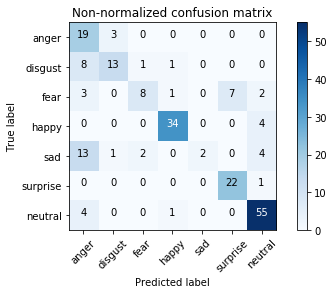

In [0]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis=1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad' , 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False,
                      title='Non-normalized confusion matrix')

# VGG16 (dataset1 + reduced 8808)

Model of original dataset with the reduced dataset. Due to chance of there being a duplicate, the reduced images were all flipped.
 - Saved as Model 9
 - Results better, but confuses:
    - fear/neutral - 28 miss predict
    - surprise with sad - 31 miss predict
    - sad with neutral/surprise/happy/anger ~15 miss predicts each

In [0]:
ls

imagereduced_dataset1/  __MACOSX/


In [0]:
directory = 'imagereduced_dataset1/'

In [0]:
#generating image data 
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(48, 48), 
        batch_size = 8808, 
        seed = 123)

Found 8808 images belonging to 7 classes.


In [0]:
#saving the data and labels into variables
images, labels = next(data_all)

In [0]:
#spliting the features and labels into train, test, and validation sets

X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [0]:
#setting base model as VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 6s 0us/step


In [0]:
#adding our own layers to train on and using softmax as the final layer activation

model = Sequential()
model.add(base_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7,activation='softmax')) #final layer with softmax activation

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#setting a stopping point depending on the validation loss for the model when it runs

early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [0]:
#compile the model
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
#freezing the layers from the base model to prevent them from being trained on

for layer in model.layers[:16]:
  layer.trainable=False
for layer in model.layers[16:]:
  layers.trainable = True

In [0]:
#run the model
model_hist = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 5636 samples, validate on 1410 samples
Epoch 1/25
5636/5636 [==============================] - 13s 2ms/step - loss: 1.8277 - acc: 0.2766 - val_loss: 1.7354 - val_acc: 0.2844
Epoch 2/25
5636/5636 [==============================] - 7s 1ms/step - loss: 1.5109 - acc: 0.4335 - val_loss: 1.1622 - val_acc: 0.5716
Epoch 3/25
5636/5636 [==============================] - 7s 1ms/step - loss: 1.1618 - acc: 0.5797 - val_loss: 0.8402 - val_acc: 0.6986
Epoch 4/25
5636/5636 [==============================] - 7s 1ms/step - loss: 0.9687 - acc: 0.6574 - val_loss: 0.8715 - val_acc: 0.6986
Epoch 5/25
5636/5636 [==============================] - 7s 1ms/step - loss: 0.8395 - acc: 0.7110 - val_loss: 0.8591 - val_acc: 0.7121
Epoch 6/25
5636/5636 [==============================] - 7s 1ms/step - loss: 0.7181 - acc: 0.7516 - val_loss: 0.6162 - val_acc: 0.7823
Epoch 7/25
5636/5636 [==============================] - 7s 1ms/step - loss: 0.6268 - acc: 0.7773 - val_loss: 0.5882 - val_acc: 0.7972
Epoch 8/25
56

In [0]:
print(classification_report(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       220
           1       0.90      0.90      0.90       185
           2       0.79      0.90      0.84       172
           3       0.89      0.92      0.90       285
           4       0.86      0.85      0.86       444
           5       0.72      0.84      0.78       201
           6       0.87      0.82      0.84       255

   micro avg       0.85      0.85      0.85      1762
   macro avg       0.85      0.85      0.85      1762
weighted avg       0.86      0.85      0.85      1762



Confusion matrix, without normalization


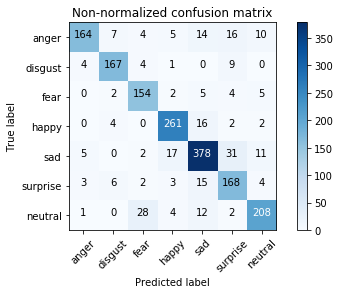

In [0]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis=1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'sad' , 'surprise', 'neutral']
plot_confusion_matrix(cm_, classes = classes_, normalize=False,
                      title='Non-normalized confusion matrix')

# VGG16 (combined data 16930)

Transfer Learning Model of the combined dataset 
*   saved as Model 10



In [0]:
ls

images/  __MACOSX/


In [0]:
directory = 'images/'

In [0]:
#generating image data 
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(48, 48), 
        batch_size = 16930, 
        seed = 123)

Found 16930 images belonging to 7 classes.


In [0]:
#saving the data and labels into variables
images, labels = next(data_all)

In [0]:
#spliting the features and labels into train, test, and validation sets
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [0]:
#setting base model as VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 2s 0us/step


In [0]:
#adding our own layers to train on and using softmax as the final layer activation

model = Sequential()
model.add(base_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7,activation='softmax')) #final layer with softmax activation

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
#setting a stopping point depending on the validation loss for the model when it runs
early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
#freezing the layers from the base model to prevent them from being trained on
for layer in model.layers[:16]:
  layer.trainable=False
for layer in model.layers[16:]:
  layers.trainable = True

In [0]:
#run the model
model_hist = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 10835 samples, validate on 2709 samples
Epoch 1/25
10835/10835 [==============================] - 19s 2ms/step - loss: 1.1147 - acc: 0.5648 - val_loss: 0.8198 - val_acc: 0.7272
Epoch 2/25
10835/10835 [==============================] - 13s 1ms/step - loss: 0.7659 - acc: 0.7415 - val_loss: 0.6538 - val_acc: 0.7870
Epoch 3/25
10835/10835 [==============================] - 13s 1ms/step - loss: 0.6226 - acc: 0.7924 - val_loss: 0.5386 - val_acc: 0.8117
Epoch 4/25
10835/10835 [==============================] - 13s 1ms/step - loss: 0.5312 - acc: 0.8231 - val_loss: 0.4867 - val_acc: 0.8372
Epoch 5/25
10835/10835 [==============================] - 14s 1ms/step - loss: 0.4807 - acc: 0.8388 - val_loss: 0.4778 - val_acc: 0.8427
Epoch 6/25
10835/10835 [==============================] - 14s 1ms/step - loss: 0.4399 - acc: 0.8533 - val_loss: 0.4351 - val_acc: 0.8571
Epoch 7/25
10835/10835 [==============================] - 14s 1ms/step - loss: 0.3886 - acc: 0.8751 - val_loss: 0.4581 - val_acc:

In [0]:
#displaying a classification report of the trained model
print(classification_report(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.73      0.50      0.59       133
           1       0.78      0.85      0.81        94
           2       0.75      0.49      0.60        87
           3       0.88      0.94      0.91      1213
           4       0.89      0.91      0.90      1583
           5       0.83      0.61      0.70       113
           6       0.70      0.63      0.66       163

   micro avg       0.87      0.87      0.87      3386
   macro avg       0.80      0.70      0.74      3386
weighted avg       0.86      0.87      0.86      3386



Confusion matrix, without normalization


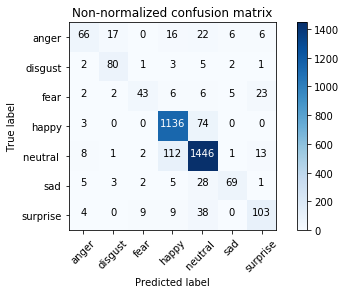

In [0]:
#displaying a confusion matrix of the model
cm_ = confusion_matrix(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis=1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'neutral ','sad' , 'surprise']
plot_confusion_matrix(cm_, classes = classes_, normalize=False,
                      title='Non-normalized confusion matrix')

#VGG16 (combined data+ flipped 33860)

Transfer Learning Model of combined data and its flipped self
*   Saved as Model 11



In [0]:
ls

images/  images_flipped/  __MACOSX/  model10.json  model_weights10.h5


In [0]:
directory = 'images_flipped/'

In [0]:
data_all = ImageDataGenerator(rescale=1./255).flow_from_directory( 
        directory, 
        target_size=(48, 48), 
        batch_size = 33860, 
        seed = 123)

Found 33860 images belonging to 7 classes.


In [0]:
images, labels = next(data_all)

In [0]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123, stratify = labels)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123, stratify = y_model)

In [0]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
model = Sequential()

In [0]:
model.add(base_model)
# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation = 'tanh'))
model.add(Dropout(0.5))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(7,activation='softmax')) #final layer with softmax activation

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 4)

In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer="sgd",
              metrics=['acc'])

In [0]:
for layer in model.layers[:16]:
  layer.trainable=False
for layer in model.layers[16:]:
  layers.trainable = True

In [0]:
model_hist = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=50,
                    validation_data=(X_val, y_val),
                  callbacks=[early_stopping])

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Train on 21670 samples, validate on 5418 samples
Epoch 1/25
21670/21670 [==============================] - 30s 1ms/step - loss: 0.9456 - acc: 0.6582 - val_loss: 0.6441 - val_acc: 0.7887
Epoch 2/25
21670/21670 [==============================] - 26s 1ms/step - loss: 0.5921 - acc: 0.8013 - val_loss: 0.8225 - val_acc: 0.7115
Epoch 3/25
21670/21670 [==============================] - 27s 1ms/step - loss: 0.4777 - acc: 0.8413 - val_loss: 0.4668 - val_acc: 0.8407
Epoch 4/25
21670/21670 [==============================] - 27s 1ms/step - loss: 0.4005 - acc: 0.8648 - val_loss: 0.5073 - val_acc: 0.8291
Epoch 5/25
21670/21670 [==============================] - 27s 1ms/step - loss: 0.3596 - acc: 0.8790 - val_loss: 0.4088 - val_acc: 0.8627
Epoch 6/25
21670/21670 [==============================] - 27s 1ms/step - loss: 0.3107 - acc: 0.8953 - val_loss: 0.3551 - val_acc: 0.8813
Epoch 7/25
21670/21670 [==============================] - 27s 1ms/step - loss: 0.2764 - acc: 0.9061 - val_loss: 0.5470 - val_acc:

In [0]:
print(classification_report(y_test.argmax(axis=1), model.predict(X_test).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       265
           1       0.85      0.91      0.88       188
           2       0.55      0.72      0.62       175
           3       0.92      0.95      0.93      2426
           4       0.92      0.88      0.90      3166
           5       0.97      0.16      0.28       226
           6       0.53      0.81      0.64       326

   micro avg       0.87      0.87      0.87      6772
   macro avg       0.78      0.73      0.71      6772
weighted avg       0.88      0.87      0.86      6772



Confusion matrix, without normalization


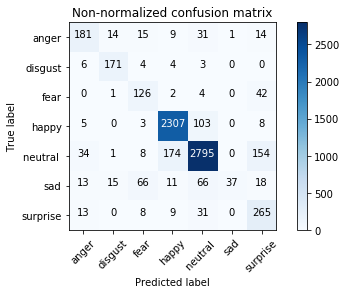

In [0]:
cm_ = confusion_matrix(y_test.argmax(axis = 1), model.predict(X_test).argmax(axis=1))
classes_ = ['anger', 'disgust', 'fear', 'happy', 'neutral ','sad' , 'surprise']
plot_confusion_matrix(cm_, classes = classes_, normalize=False,
                      title='Non-normalized confusion matrix')

# Saving Model Weights

In [0]:
#saving the model and its weights

model_json = model.to_json()
with open("model11.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weights11.h5")
print("Saved model to drive")

Saved model to drive
